In [423]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyproj  #conda install pyproj


In [424]:
propiedades = pd.read_csv('properati.csv')

/home/mati/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#Ya no es necesario 

#Elimino columnas innecesarias
#propiedades.drop(['id', 'geonames_id', 'lat-lon', 'properati_url', 'description', 'title', 'image_thumbnail'], axis = 1, inplace = True)
propiedades.head(2)


In [ ]:
propiedades.info()

In [ ]:
#ya no es necesario

#Elimino los registros que no sean de Capital Federal o Gran Buenos Aires
#capital = propiedades ['state_name'] == 'Capital Federal'
#gba = propiedades ['state_name'].str.contains('Bs.As. G.B.A.')
#propiedades = propiedades [capital | gba].reset_index()
#propiedades.drop("index", axis = 1, inplace = True)
#propiedades.info()

# podemos reemplazar es por la siguiente linea creo 
#( no lo hice porque en el repo no esta el csv y no se cual tenias)
# propiedades = propiedades.loc[propiedades.state_name.str.contains('Bs.As. G.B.A.|Capital Federal'),:]

In [ ]:
#Compruebo que solo haya capital y gba
propiedades.groupby('state_name').agg(np.size)['operation']

In [425]:
#Reemplazo todos los tipos de Palermo por uno unico
propiedades.loc[propiedades.place_name.str.contains("Palermo", na = False),'place_name'] = 'Palermo'
propiedades.loc[propiedades.place_name.str.contains("Palermo", na = False),'place_name'].value_counts()

Palermo    107108
Name: place_name, dtype: int64

In [426]:
def calcularPrecioM2(fila):
    """Recibe una lista con precio total, superficie total, superficie cubierta y precio por metro cuadrado,
    y calcula este ultimo a partir de los anteriores, cuando es posible"""
    precio_total,superficie_total,superficie_cubierta,precio_m2 = fila
    if (np.isnan(precio_m2)):
        if (superficie_total and not np.isnan(superficie_total)):
            return precio_total/superficie_total
        if(superficie_cubierta and not np.isnan(superficie_cubierta)):
            return precio_total/superficie_cubierta
    return precio_m2

In [427]:
#Calculo el precio por metro cuadrado a partir del precio total y la superficie
propiedades.loc[:,'price_usd_per_m2'] = propiedades.loc[:,['price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','price_usd_per_m2']].apply(calcularPrecioM2,axis = 1)
propiedades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580055 entries, 0 to 2580054
Data columns (total 21 columns):
country_name                  object
created_on                    object
currency                      object
expenses                      object
floor                         float64
lat                           float64
lon                           float64
operation                     object
place_name                    object
place_with_parent_names       object
price                         float64
price_aprox_local_currency    float64
price_aprox_usd               float64
price_per_m2                  float64
price_usd_per_m2              float64
property_type                 object
rooms                         float64
state_name                    object
surface_covered_in_m2         float64
surface_in_m2                 float64
surface_total_in_m2           float64
dtypes: float64(12), object(9)
memory usage: 413.4+ MB


### Como es el precio por metro cuadrado en cada zona? Cuales son los barrios con mayor promedio?

In [ ]:
tiene_precio = propiedades['price_usd_per_m2'].notnull()
precio_por_zona = propiedades[tiene_precio].loc[:,['state_name','price_usd_per_m2']].groupby('state_name').agg([np.size,np.mean])
precio_por_zona

In [ ]:
plot = precio_por_zona[('price_usd_per_m2','mean')].sort_values(ascending = False).plot(kind='barh', title = "Precio por metro cuadrado promedio segun la zona", figsize=(12,8));
plot.set_ylabel("Zona")
plot.set_xlabel("Precio por metro cuadrado")

### Para capital federal

In [ ]:
precios_capital = propiedades[tiene_precio].loc[propiedades.state_name == 'Capital Federal',['place_name','price_usd_per_m2']]
precios_capital = precios_capital.groupby('place_name').agg([np.size,np.mean])
precios_capital.describe()

In [ ]:
#Tomamos solo aquellos barrios que tengan mas de 800 publicaciones
precios_capital = precios_capital[precios_capital[('price_usd_per_m2','size')] > 800]

In [ ]:
plot = precios_capital[('price_usd_per_m2','mean')].sort_values(ascending = False).head(10).plot(kind='bar', figsize=(12,8));
plot.set_xlabel("Barrio")
plot.set_ylabel("Precio por metro cuadrado")
plot.set_title("Precio por metro cuadrado para barrios de Capital Federal")

### Para gba zona norte

In [ ]:
precios_zona_norte = propiedades[tiene_precio].loc[propiedades.state_name.str.contains('Zona Norte'),['place_name','price_usd_per_m2']]
precios_zona_norte = precios_zona_norte.groupby('place_name').agg([np.size,np.mean])
precios_zona_norte.describe()

In [ ]:
#Tomamos solo aquellos barrios que tengan mas de 800 publicaciones
precios_zona_norte = precios_zona_norte[precios_zona_norte[('price_usd_per_m2','size')] > 800]
plot = precios_zona_norte[('price_usd_per_m2','mean')].sort_values(ascending = False).head(10).plot(kind='bar', figsize=(12,8));
plot.set_xlabel("Barrio")
plot.set_ylabel("Precio por metro cuadrado")
plot.set_title("Precio por metro cuadrado para barrios de GBA Zona Norte")

### Para gba zona oeste

In [ ]:
precios_zona_oeste = propiedades[tiene_precio].loc[propiedades.state_name.str.contains('Zona Oeste'),['place_name','price_usd_per_m2']]
precios_zona_oeste = precios_zona_oeste.groupby('place_name').agg([np.size,np.mean])
precios_zona_oeste.describe()

In [ ]:
#Tomamos solo aquellos barrios que tengan mas de 800 publicaciones
precios_zona_oeste = precios_zona_oeste[precios_zona_oeste[('price_usd_per_m2','size')] > 800]
plot = precios_zona_oeste[('price_usd_per_m2','mean')].sort_values(ascending = False).head(10).plot(kind='bar', figsize=(12,8));
plot.set_xlabel("Barrio")
plot.set_ylabel("Precio por metro cuadrado")
plot.set_title("Precio por metro cuadrado para barrios de GBA Zona Oeste")

### Para gba zona sur

In [ ]:
precios_zona_sur = propiedades[tiene_precio].loc[propiedades.state_name.str.contains('Zona Sur'),['place_name','price_usd_per_m2']]
precios_zona_sur = precios_zona_sur.groupby('place_name').agg([np.size,np.mean])
precios_zona_sur.describe()

In [ ]:
#Tomamos solo aquellos barrios que tengan mas de 800 publicaciones
precios_zona_sur = precios_zona_sur[precios_zona_sur[('price_usd_per_m2','size')] > 800]
plot = precios_zona_sur[('price_usd_per_m2','mean')].sort_values(ascending = False).head(10).plot(kind='bar', figsize=(12,8));
plot.set_xlabel("Barrio")
plot.set_ylabel("Precio por metro cuadrado")
plot.set_title("Precio por metro cuadrado para barrios de GBA Zona Sur")

### Como evoluciono el precio por metro cuadrado al pasar los anios?

In [ ]:
def obtener_anio(fecha):
    return fecha.split('-')[0]


In [ ]:
def obtener_mes(fecha):
    return fecha.split('-')[1]

In [ ]:
propiedades.loc[:,'Year'] = propiedades.loc[:,'created_on'].apply(obtener_anio)
propiedades.loc[:,'Month'] = propiedades.loc[:,'created_on'].apply(obtener_mes)
propiedades.tail(3)

In [ ]:
precio_por_anio = propiedades[tiene_precio].loc[:,['Year','price_usd_per_m2']].groupby('Year').agg([np.size,np.mean])
precio_por_anio = precio_por_anio.loc[precio_por_anio[('price_usd_per_m2','size')] > 100,:]
precio_por_anio

In [ ]:
plot = precio_por_anio[('price_usd_per_m2','mean')].plot(figsize=(12,8));
plot.set_xlabel("Año")
plot.set_ylabel("Precio por metro cuadrado promedio")
plot.set_ylim([0,3000])
plot.set_title("Evolucion del precio por metro cuadrado a lo largo de los años")

In [ ]:
precio_por_anio2 = propiedades.loc[propiedades.price_aprox_usd.notnull(),['Year','price_aprox_usd']].groupby('Year').agg([np.size,np.mean])
precio_por_anio2 = precio_por_anio2.loc[precio_por_anio2[('price_aprox_usd','size')] > 100,:]
plot = precio_por_anio2[('price_aprox_usd','mean')].plot(figsize=(12,8));
plot.set_xlabel("Año")
plot.set_ylabel("Precio promedio")
plot.set_ylim([0,270000])
plot.set_title("Evolucion del precio a lo largo de los años")

### Como evoluciono el precio por metro cuadrado en en cada anio?

In [ ]:
precios_2016 = propiedades[tiene_precio].loc[propiedades.Year == '2016',['Month','price_usd_per_m2']].groupby('Month').agg(np.mean)
precios_2015 = propiedades[tiene_precio].loc[propiedades.Year == '2015',['Month','price_usd_per_m2']].groupby('Month').agg(np.mean)
precios_2014 = propiedades[tiene_precio].loc[propiedades.Year == '2014',['Month','price_usd_per_m2']].groupby('Month').agg(np.mean)


In [ ]:
precios_2016 = precios_2016.rename(columns={'price_usd_per_m2': '2016'}).reset_index()
precios_2015 = precios_2015.rename(columns={'price_usd_per_m2': '2015'}).reset_index()
precios_2014 = precios_2014.rename(columns={'price_usd_per_m2': '2014'}).reset_index()
precios = pd.merge(precios_2016,precios_2015,on='Month',how='outer')
precios = pd.merge(precios,precios_2014,on='Month',how='outer')
precios.set_index('Month', inplace = True)
precios

In [ ]:
precios.index = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto',\
                 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
plot = precios.plot(figsize=(12,8),rot = 50);
plot.set_xlabel("Mes")
plot.set_ylabel("Precio por metro cuadrado promedio")
plot.set_title("Evolucion del precio por metro cuadrado a lo largo de los meses")
plot.set_ylim([0,3000])


### Que tipo de propiedad se vende mas?

In [ ]:
tipos_propiedades = propiedades.loc[:,'property_type'].str.capitalize().value_counts()
plot = tipos_propiedades.plot(kind='pie', figsize=(12,8), autopct='%.2f', label = 'Tipo de Propiedad');
plot.set_title("Porcentaje de publicaciones de cada tipo de propiedad")

In [ ]:
precio_tipos_propiedades = propiedades.loc[:,['property_type','price_aprox_usd']]
precio_tipos_propiedades.loc[:,'property_type'] = precio_tipos_propiedades.loc[:,'property_type'].str.capitalize()
precio_tipos_propiedades = precio_tipos_propiedades.groupby('property_type').agg([np.size,np.mean])
plot = precio_tipos_propiedades.loc[:,('price_aprox_usd','mean')].sort_values(ascending=False).plot(kind = 'bar');

plot.set_xlabel("Tipo de propiedad")
plot.set_ylabel("Precio promedio (en dolares)")
plot.set_title("Precio segun el tipo de propiedad")

### Cual es la relacion entre la superficie cubierta y la cantidad de habitaciones?

In [ ]:
tiene_superficie = propiedades['surface_covered_in_m2'].notnull()
tiene_habitaciones = propiedades['rooms'].notnull()
habitaciones = propiedades.loc[tiene_superficie & tiene_habitaciones,:]
habitaciones = habitaciones.loc[(habitaciones['surface_covered_in_m2'] < 500) & (habitaciones['rooms'] < 15 ),:]
habitaciones.plot.scatter(x = 'surface_covered_in_m2', y = 'rooms', figsize=(12,8))

In [ ]:
tiene_precio_usd = propiedades['price_aprox_usd'].notnull()
tiene_habitaciones = propiedades['rooms'].notnull() & propiedades['rooms'] > 0
hab = propiedades.loc[tiene_precio_usd & tiene_habitaciones,:]
hab = hab.loc[(hab['price_aprox_usd'] > 1000) & (hab['price_aprox_usd'] < 100000) & (hab['rooms'] < 10),:]
plot = hab.plot.scatter(x = 'price_aprox_usd', y = 'rooms', figsize=(12,8));
plot.set_xlabel("Precio de la propiedad (en dolares)")
plot.set_ylabel("Cantidad de habitaciones")
plot.set_title("Relacion entre la cantidad de habitaciones y el precio de la propiedad")

##### se ve que las propiedades mas baratas no tiene mas de 4-5 habitaciones y que solo las mas caras tiene mas de 6

### Relacion entre los distintos valores de dolar (Creo que no sirve para comparar)

In [ ]:
valor_dolar = propiedades.loc[(propiedades['price_aprox_local_currency'].notnull()) & (propiedades['price_aprox_usd'].notnull()),['price_aprox_local_currency','price_aprox_usd','Year']]
valor_dolar ['dolar'] = valor_dolar['price_aprox_local_currency'] / valor_dolar['price_aprox_usd']
valor_dolar = valor_dolar[valor_dolar ['dolar'] > 10]
valor_dolar.describe()

In [ ]:
valor_dolar = valor_dolar.loc[:,['Year', 'dolar']].groupby('Year').agg(np.mean)
valor_dolar

## Tomamos algunos barrios importantes y hacemos comparaciones

In [ ]:
barrios = ['Palermo', 'Olivos', 'Lomas de Zamora', 'La Matanza']
df = []
for barrio in barrios:
    a = propiedades[tiene_precio].loc[propiedades.place_name == barrio,['Year','price_usd_per_m2']]\
    .groupby('Year').agg(np.mean).reset_index().rename(columns={'price_usd_per_m2' : barrio})
    df.append(a)

In [ ]:
precios_barrios = df[0]
for x in range (1,len(barrios)):
    precios_barrios = pd.merge(precios_barrios,df[x],how='outer')
precios_barrios.set_index("Year",inplace = True)
precios_barrios

In [ ]:
plot = precios_barrios.plot(figsize=(12,8));
plot.set_xlabel("Año")
plot.set_ylabel("Precio promedio por metro cuadrado")
plot.set_title("Evolucion del precio por metro cuadrado a lo largo de los años para algunos barrios")
plot.set_ylim([0,3600])

In [ ]:
precios_barrios2 = propiedades.loc[(propiedades.Year == '2016') & (propiedades.price_usd_per_m2 < 5000) &\
                        (propiedades.price_usd_per_m2 > 100)&((propiedades.place_name == barrios[0]) | \
                          (propiedades.place_name == barrios[1]) | (propiedades.place_name == barrios[2])\
                        | (propiedades.place_name == barrios[3])),\
        ['lon','place_name','price_usd_per_m2']].pivot_table(index='lon',columns='place_name')
precios_barrios2.columns = precios_barrios2.columns.droplevel()
boxplot = precios_barrios2.plot.box(figsize=(12,8),patch_artist=True,return_type='dict', title="Precio por metro cuadrado para algunos barrios");
ax=plt.gca()
ax.set_ylabel('Precio por metro cuadrado')
ax.set_xlabel('Barrio')


colors = ['red' , 'green', 'orange', 'blue'] #Mismos colores del grafico de lineas de arriba
    
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)


## Relacion entre precios y distancia a lugares importantes

In [429]:
def calcular_distancia(lat1,long1,lat2,long2):
    geod = pyproj.Geod(ellps="WGS84")
    angle1,angle2,distance = geod.inv(long1, lat1, long2, lat2)
    return distance / 1000

#https://joseguerreroa.wordpress.com/2012/11/09/desarrollo-geoespacial-con-python-en-linux-debian/

In [432]:
def calcular_distancia_minima(fila):

    lugares = ['Obelisco','Cabildo','Planetario','Jardin Botanico','Abasto','Museo del arte']
    latitudes = [-34.603075,-38.4833,-34.569722,-34.582639,-34.603611,-34.57722222]
    longitudes = [-58.381653,-61.9,-58.411667,-58.417361,-58.410833,-58.40336111]
    lat1,long1 = fila
    distancias = []
    
    for i in range(len(lugares)):
        distancias.append(calcular_distancia(lat1,long1,latitudes[i],longitudes[i]))
    
    return min(distancias)

In [436]:
solo_capital = propiedades.loc[(propiedades.state_name == 'Capital Federal') & (propiedades.lat.notnull()) & (propiedades.lon.notnull()),:]
solo_capital = solo_capital.loc[((solo_capital.lat <= -32) & (solo_capital.lat >= -36)),:]
solo_capital = solo_capital.loc[((solo_capital.lon <= -56) & (solo_capital.lon >= -63)),:]
solo_capital.loc[:,'distancia'] = solo_capital.loc[:,['lat','lon']].apply(calcular_distancia_minima, axis = 1)
solo_capital.head(2)

,country_name,created_on,currency,expenses,floor,lat,lon,operation,place_name,place_with_parent_names,...,price_aprox_usd,price_per_m2,price_usd_per_m2,property_type,rooms,state_name,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,distancia
0,NaN,2012-08-08,NaN,850 aprox,10.0,-34.561208,-58.464514,sell,Belgrano,|Argentina|Capital Federal|Belgrano|,...,NaN,NaN,NaN,apartment,3.0,Capital Federal,NaN,102.0,NaN,4.936932
10,NaN,2012-08-08,USD,NaN,10.0,-34.597915,-58.417149,sell,Palermo,|Argentina|Capital Federal|Palermo|,...,86925.0,NaN,2716.40625,apartment,1.0,Capital Federal,NaN,32.0,NaN,0.857280


In [438]:
solo_capital.describe()

,floor,lat,lon,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,price_usd_per_m2,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,distancia
count,227690.000000,888975.000000,888975.000000,8.057660e+05,8.057640e+05,8.057640e+05,2.894650e+05,6.564670e+05,676188.000000,314934.000000,406132.000000,261386.000000,888975.000000
mean,13.340841,-34.596565,-58.442261,3.232270e+05,2.581489e+06,2.248059e+05,4.948301e+03,2.638937e+03,2.488339,97.201788,96.126629,120.697149,4.342562
std,89.266207,0.044198,0.067201,9.993874e+05,4.863087e+06,3.555383e+05,2.358900e+04,8.548444e+03,1.429751,461.269649,443.047143,1030.537096,6.480397
min,0.000000,-35.765171,-62.700426,0.000000e+00,0.000000e+00,0.000000e+00,2.224587e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.023225
25%,2.000000,-34.619078,-58.468460,9.600000e+04,8.484106e+05,9.285935e+04,2.031250e+03,1.756757e+03,1.000000,39.000000,41.000000,43.000000,1.467435
50%,4.000000,-34.598670,-58.438988,1.490000e+05,1.410412e+06,1.350000e+05,2.575758e+03,2.212121e+03,2.000000,59.000000,58.000000,67.000000,3.040989
75%,8.000000,-34.577777,-58.406625,3.000000e+05,2.619189e+06,2.300000e+05,3.363636e+03,2.781250e+03,3.000000,103.000000,100.000000,121.000000,5.597755
max,8661.000000,-32.659826,-56.159084,2.418570e+08,8.212711e+08,4.654544e+07,4.243105e+06,2.600000e+06,40.000000,187000.000000,105000.000000,200000.000000,450.797818


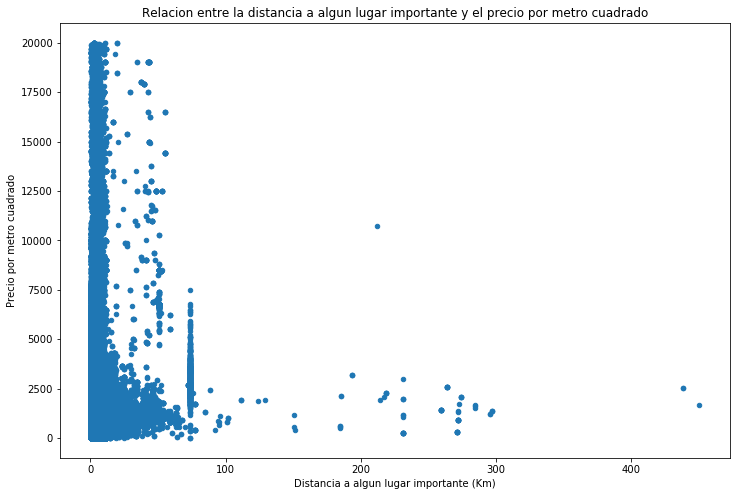

In [439]:
dist = solo_capital.loc[(solo_capital.price_usd_per_m2.notnull()) & (solo_capital.price_usd_per_m2 < 20000),:]
plot = dist.plot.scatter(x = 'distancia', y = 'price_usd_per_m2', figsize=(12,8));
plot.set_xlabel("Distancia a algun lugar importante (Km)")
plot.set_ylabel("Precio por metro cuadrado")
plot.set_title("Relacion entre la distancia a algun lugar importante y el precio por metro cuadrado")

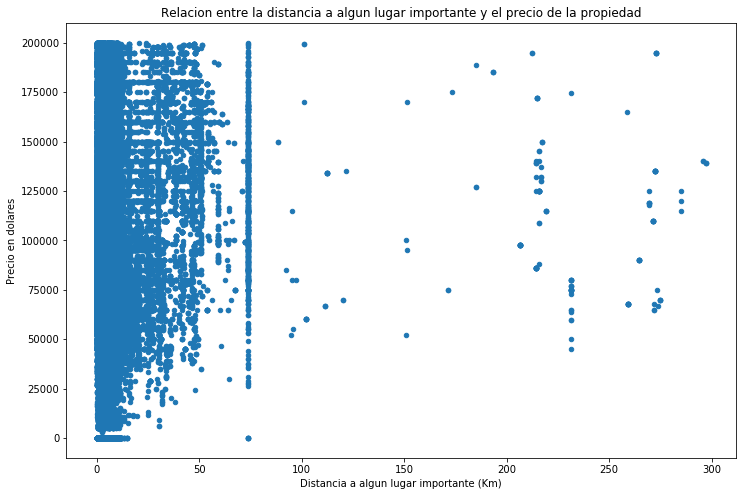

In [440]:
dist2 = solo_capital.loc[(solo_capital.price_aprox_usd.notnull()) & (solo_capital.price_aprox_usd < 200000),:]
plot = dist2.plot.scatter(x = 'distancia', y = 'price_aprox_usd', figsize=(12,8));
plot.set_xlabel("Distancia a algun lugar importante (Km)")
plot.set_ylabel("Precio en dolares")
plot.set_title("Relacion entre la distancia a algun lugar importante y el precio de la propiedad")